In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import casadi as ca
import casadi.tools as ct

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [10]:
# Hyperparams
dt = 0.01; fs = 1/dt
g = 9.8
# Parameters - motor
R = 9.5
L = 0.84E-3
K = 53.6E-3
J = 2.2E-4
b = 6.6E-5
m = 0.07
l = 0.042
# Parameters - model reference
A_m = 0.99
B_m = 0.01
C_m = 1
D_m = 0

In [11]:
def servo_motor(x, u, ts):
    """ System dynamics function (discrete time)
    """
    
    theta = x['theta']
    omega = x['omega']
    I = x['I']
    
    
    # state derivative expression
    xdot = (ca.mtimes(np.array([[0, 1, 0],[0, -b/J, K/J],[0, -K/L, -R/L]]) +
            np.array([[0, 1, 0],[m*g*l, 0, 0],[0, 0, 0]]) * np.sin(theta)/theta,
            ca.vertcat(theta,omega,I))
            + ca.mtimes(np.array([[0],[0],[1/L]]), u))
    
    # create ode for integrator
    ode = {'x':x, 'p':u,'ode': xdot}

    return [ca.integrator('F','collocation',ode,{'tf':ts}), ode]

def vars():

    """ System states and controls
    """

    x = ct.struct_symMX(['theta','omega','I'])
    u = ct.struct_symMX(['V'])

    return x, u

In [12]:
# set-up system
x, u = vars()
f = servo_motor(x, u, dt)[0]
res = f(x0=x, p=u)
x_next = res['xf'] # Access x_next as the DAE symbolic solution
# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = ca.Function('F',[x,u],[x_next],['x','u'],['x_next'])

# Define values for x and u
x_s = [1e-6, 50, 1e-6]
u_s = [1e-6]

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

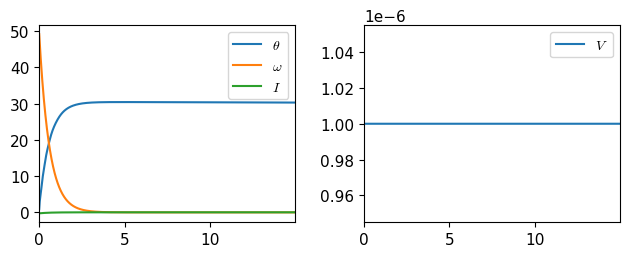

In [13]:
# Simulation parameters
T = 15
Ts = 0.01
t = np.arange(0,T,Ts)

X_log = np.empty((3,0))
U_log = np.empty((1,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

for i in range(len(t)):
    # print(i)
    s = x_0
    a = u_0
    
    s_next = F(s, a)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a))
    X_log = np.column_stack((X_log, x_0))

plt.subplot(221)    
plt.plot(t, X_log[0,:], label=r"$\theta$")
plt.plot(t, X_log[1,:], label=r"$\omega$")
plt.plot(t, X_log[2,:], label="$I$")
plt.legend()
plt.grid()

plt.subplot(222)    
plt.plot(t, U_log[0,:], label="$V$")
plt.legend()
plt.grid()


plt.tight_layout()

#plt.savefig("../fig/jacobians_ss.pdf")

In [14]:
from control.matlab import *
t = np.arange(0,dt*1500,dt)
u = np.random.normal(0, 16, 1500)
s = tf('s')
tau = 1/(1.6*2*np.pi)
F_input = 1/(1 + tau*s)
u_filtered = lsim(F_input, u, t)[0]

/home/rbusetto/.conda/envs/transformers-control/lib/python3.10/site-packages/control/timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

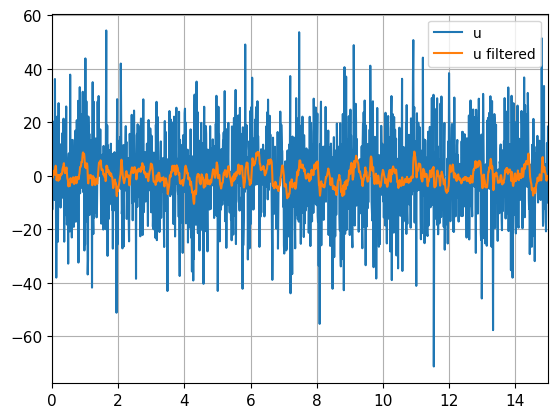

In [15]:
plt.plot(t, u, label='u')
plt.plot(t, u_filtered, label='u filtered')
plt.legend()

In [16]:
y = np.zeros((len(u_filtered), 3))
# Simulate the system
for i in range(len(u_filtered)):
    s = x_0
    y[i,:] = s
    a = u_filtered[i]
    s_next = F(s, a)
    x_0 = np.array(s_next).flatten()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

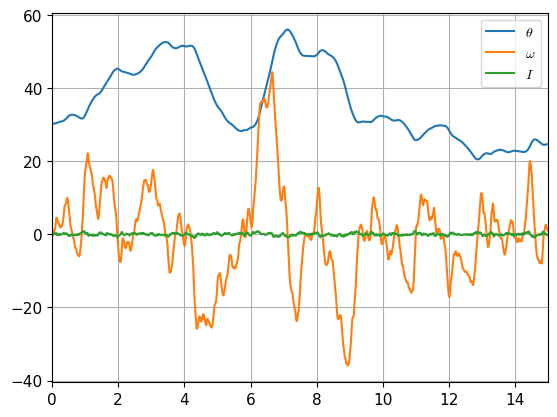

In [17]:
# Plot the response
plt.figure(1)
plt.plot(t, y[:,0])
plt.plot(t, y[:,1])
plt.plot(t, y[:,2])
plt.legend([r'$\theta$', '$\omega$', '$I$'])
plt.show(block=False)

In [10]:
M = tf(ss(A_m, B_m, C_m, D_m, dt))
z = tf('z')
r_v = lsim((z*M)**(-1), y[:,0], t)[0]
e_v = r_v - y[:,0]

In [11]:
u_1 = np.roll(u_filtered, 1); u_1[:1] = 0
u_2 = np.roll(u_filtered, 2); u_2[:2] = 0
u_3 = np.roll(u_filtered, 3); u_3[:3] = 0
u_4 = np.roll(u_filtered, 4); u_4[:4] = 0
e_v_1 = np.roll(e_v, 1); e_v_1[:1] = 0
e_v_2 = np.roll(e_v, 2); e_v_2[:2] = 0
e_v_3 = np.roll(e_v, 3); e_v_3[:3] = 0
e_v_4 = np.roll(e_v, 4); e_v_4[:4] = 0
e_v_0 = e_v

from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X = np.array([u_1, u_2, u_3, u_4, e_v, e_v_1, e_v_2, e_v_3, e_v_4])
X = X.T
X = X_scaler.fit_transform(X)

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False).fit(X, u_filtered)
print(model.score(X, u_filtered))

0.9343145112306714


In [13]:
a1, a2, a3, a4 = model.coef_[:4]
b0, b1, b2, b3, b4 = model.coef_[4:]

In [14]:
num = [b4, b3, b2, b1, b0]
den = [a4, a3, a2, a1,  0]
C = tf(num, den, dt)

In [15]:
t_CL = np.arange(0, 50, dt)
r = np.zeros(t_CL.shape)
r[t_CL < 5] = 2.7
r[(t_CL >= 5) & (t_CL < 10)] = 3.6
r[(t_CL >= 10) & (t_CL < 15)] = 4.1
r[(t_CL >= 15) & (t_CL < 25)] = 3.8
r[(t_CL >= 25) & (t_CL < 35)] = 2.1
r[(t_CL >= 35)] = 4.1

C:\Users\ricca\anaconda3\envs\sysid-transformers-control\Lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\ricca\anaconda3\envs\sysid-transformers-control\Lib\site-packages\control\timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


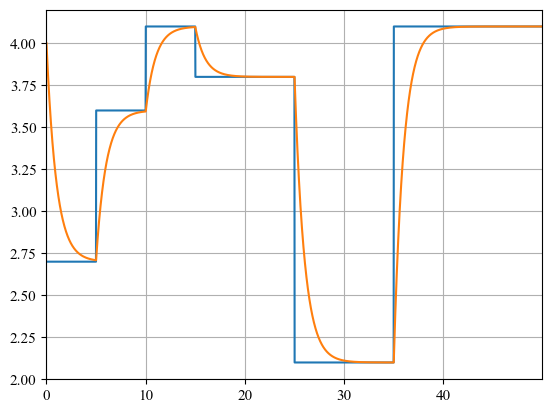

In [16]:
y_d = lsim(M, r, t_CL, X0=np.array([40]))[0]
plt.plot(t_CL, r)
plt.plot(t_CL, y_d)